# LSTM for Time Series Prediction in PyTorch

> Run:    
> Personally, running it in a dockerized, gpu/cuda-enabled pytorch/notebook environment (cf. [github/gpu-jupyter](https://github.com/iot-salzburg/gpu-jupyter))

- *Updated from this source [article](https://machinelearningmastery.com/lstm-for-time-series-prediction-in-pytorch/)*, with famous "Airline" dataset  
- *What was **added** :*  
    - clarifies steps / order making data stationary / normalization (a common mistake/lack of in a lot of online ressources)
    - Make data stationary (first order diff). Not mandatory with a lstm but very common, recommended and usually improves performance
    - More structure / pipelined : transform functions (normalize / inverse diff via cumsum etc.), steps / notes on arrays shape etc.   
    - Normalization (minmax)
    - Input size (lookback) directly set to 4 (vs. 1, then 4)
    - benchmark models accuracy with and without statio. + scaling

### Tl:dr - conclusion

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

### Load data

In [2]:
df = pd.read_csv('data/airline-passengers.csv')
df.head(2)

,Month,Passengers
0,1949-01,112
1,1949-02,118


Drop index (year-month) and keep dependent variable as a Series of float

In [3]:
#for a 2d array, would be like below, but for easier transformations etc, we chose 1D array format
ts2 = df[["Passengers"]].values.astype('float32')
ts2[0:3]

array([[112.],
       [118.],
       [132.]], dtype=float32)

In [4]:
ts2.shape

(144, 1)

In [5]:
# for 1d array
ts = df["Passengers"].values.astype('float32')
ts[0:3]

array([112., 118., 132.], dtype=float32)

In [6]:
ts.shape

(144,)

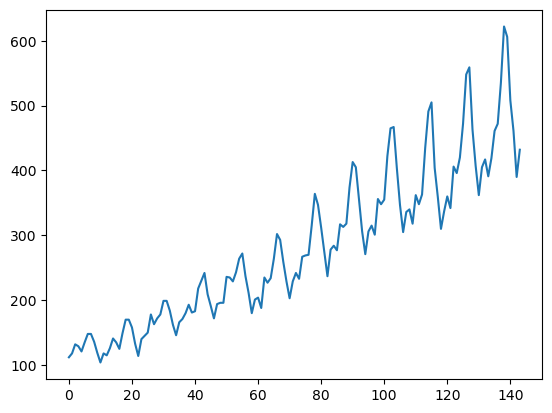

In [7]:
plt.plot(ts)

### Steps overview. Order matters

- 1. check if stationary / make stationary (e.g first order or other method). Ok to be before train/test split
- 2. train - test split, **before** applying scaling (normalization), to avoid information leakage
- 3. apply normalization, minmax is recommended for lstm / time series prediction. Fit on train test, transform train / test sets
- 4. define how you want the nn to predict : define the look back windows / input width = how much data allowed to look at when make prediction
- 5. create dataset : loop back + tensor shape to be compatible with Pytorch / LSTM
- 6. create model as a class, or function
- 7. train model & eval : loss function MSE (because regression), minimized by Adam optimizer.

### Train test split

In [8]:
# input/output 1D array time series (ts)
train_size = int(len(ts) * 0.67)
test_size = len(ts) - train_size
train, test = ts[:train_size], ts[train_size:]

### Preprocessing / post-processing (make/revert stationary, normalize)

From plot, data clearly strong, linear trend, not stationary at all -> we make data stationary, using built-in diff method in numpy (first order diff). We will also make sure to save first value to be able to revert the diff.  

**Preprocessing / post-processing functions:**

Note on input/output data shape 
We're using 1D array with 1 feature as input/output of our transformations steps for convenience/consistency  
When needed, we reshape data e.g. minmax scaler from sklearn need 2D array as input. But we keep output as 1D.  
Later on (LSTM prep), this will change (2D/3D)

In [9]:
# Dave first value ("offset") for later easy un-differenciating with cumsum + offset
def get_offset(time_series: np.array) -> float:
    """
    Save offset, for later reverse differenciating
    Notes i/o:
    Input 1d array time series
    """
    return time_series[0]

# Differentiate (here first order)
def make_stationary(time_series: np.array) -> np.array:
    """
    Make Time Series stationary (remove trend), using first order difference
    Not mandatory with a lstm but very common, recommended and usually improves performance
    Notes i/o:
    - 1d array time series
    - Apply on whole dataset, or after train-test, should not matter that much cause we're only using previous value.
    - source : https://datascience.stackexchange.com/questions/96876/applying-differencing-on-a-time-series-before-or-after-train-and-test-split
    
    """
    ts_stationary = np.diff(time_series)
    return ts_stationary

# func to revert differentiating; with input "offset"
def revert_differenciating(time_series: np.array, offset, add_offset=False) -> np.array:
    """
    Revert first order differenciating, using saved offset
    Re-input offset (first value) at timeseries start is not really mandatory
    Use it if you do not want to lose the original length of the timeseries
    """
    ts_undiff = np.cumsum(time_series)
    ts_undiff = ts_undiff + offset
    # optional : add back original first value (differenciating removed our 1st value)
    if add_offset:
        ts_undiff = np.insert(ts_undiff, 0, offset)
    return ts_undiff

def revert_differenciating2(time_series: np.array, offset, add_offset=False) -> np.array:
    ts_undiff = np.concatenate(([offset], time_series)).cumsum()
    return ts_undiff

# scale data, recommended for LSTM is minmax,
# but for time series if strong trend (up or down) might not be the best
# because future data max/low might being out of bound ; domain knowledge can help too.
def normalize(time_series: np.array) -> np.array:
    """
    Apply min max scaler, fit on train
    Reminder : fit on train set only, then transform both train and test
    Input is 1D array
    """
    scaler = MinMaxScaler(feature_range=(0, 1))
    # test.reshape(-1,1) : input array must be reshape to a 2D array prior norma
    scaler_min_max = scaler.fit(time_series.reshape(-1,1))
    ts_normalized = scaler_min_max.transform(time_series.reshape(-1,1))
    # back to 1D
    ts_normalized_1D = ts_normalized.flatten()
    return scaler_min_max, ts_normalized_1D

def inverse_normalize(scaler, time_series: np.array) -> np.array:
    """Reverse min max scaler. Input is 1D array"""
    time_series_inverse = scaler.inverse_transform(time_series.reshape(-1, 1))
    time_series_inverse_1D = time_series_inverse.flatten()
    return time_series_inverse_1D

def to_2d(array: np.array) -> np.array:
    """Convenience function for code transparency when we convert 1D array to 2D"""
    array2 = array.reshape(-1,1)
    return array2

def to_1d(array: np.array) -> np.array:
    """Convenience function for code transparency when we convert 2D array to 1D"""
    array2 = array.flatten()
    return array2

### Optional : test & viz for transfo. (station., scaling) - inverse transform  / data distribution

### Test reverse differencing

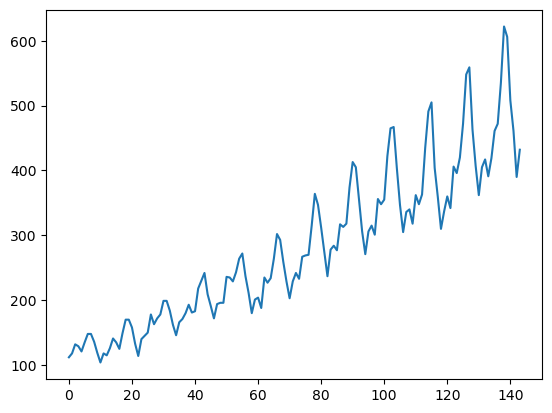

In [10]:
# original data (all)
plt.plot(ts)

53


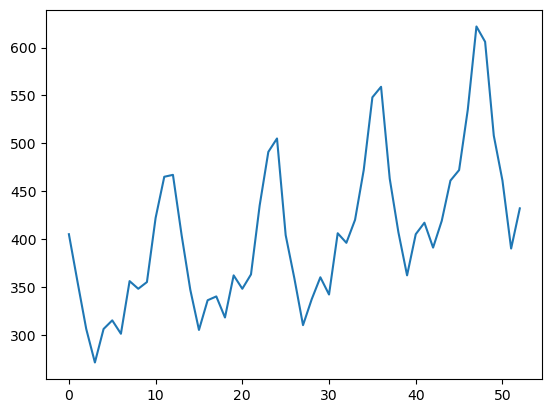

In [11]:
# test data only
ts_test = ts[91:]
plt.plot(ts_test)
print(len(ts_test))

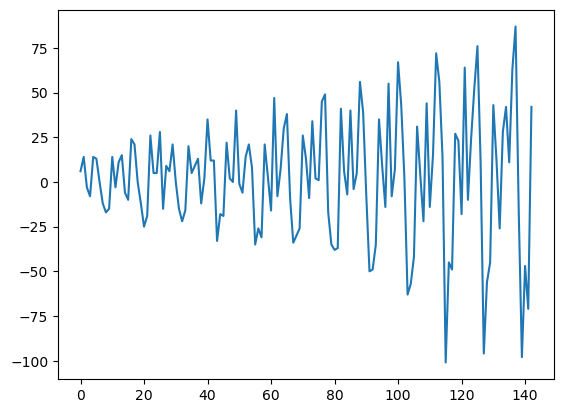

In [12]:
# make stationary (all data)
ts_stationary = make_stationary(ts)
plt.plot(ts_stationary)

52


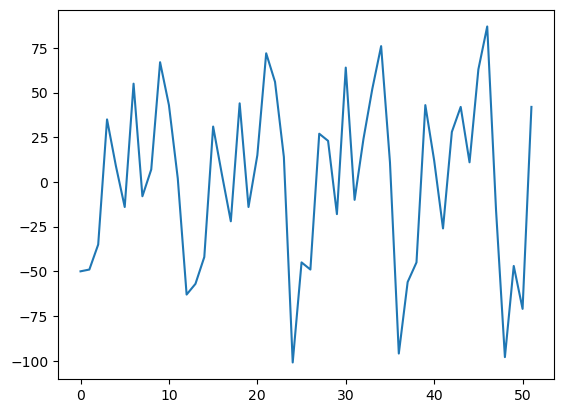

In [13]:
# make stationary (test data)
ts_test_stationary = make_stationary(ts_test)
plt.plot(ts_test_stationary)
print(len(ts_test_stationary))

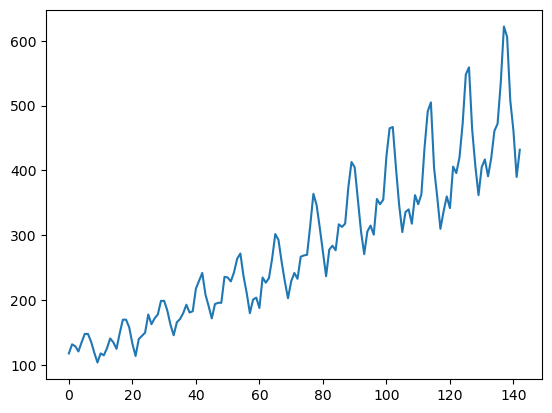

In [14]:
# revert differencing (all data)
ts_reverted = revert_differenciating(ts_stationary, 112)
plt.plot(ts_reverted)

405.0
53


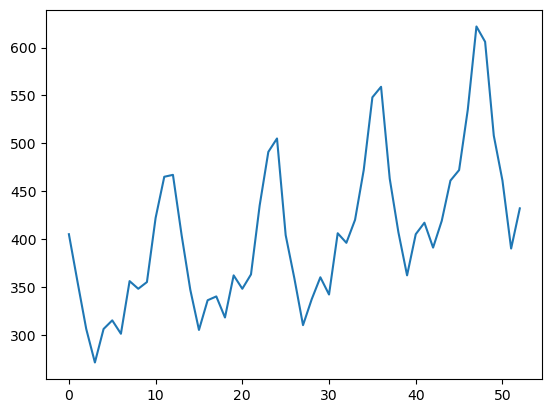

In [15]:
# revert differencing (test data)
print(ts_test[0])
# ts_test_reverted = revert_differenciating(ts_test_stationary, 405)
ts_test_reverted = revert_differenciating2(ts_test_stationary, 405)
plt.plot(ts_test_reverted)
print(len(ts_test_reverted))

#### Make stationary / revert differenciating

In [16]:
offset = get_offset(ts)
offset

112.0

In [17]:
ts

array([112., 118., 132., 129., 121., 135., 148., 148., 136., 119., 104.,
       118., 115., 126., 141., 135., 125., 149., 170., 170., 158., 133.,
       114., 140., 145., 150., 178., 163., 172., 178., 199., 199., 184.,
       162., 146., 166., 171., 180., 193., 181., 183., 218., 230., 242.,
       209., 191., 172., 194., 196., 196., 236., 235., 229., 243., 264.,
       272., 237., 211., 180., 201., 204., 188., 235., 227., 234., 264.,
       302., 293., 259., 229., 203., 229., 242., 233., 267., 269., 270.,
       315., 364., 347., 312., 274., 237., 278., 284., 277., 317., 313.,
       318., 374., 413., 405., 355., 306., 271., 306., 315., 301., 356.,
       348., 355., 422., 465., 467., 404., 347., 305., 336., 340., 318.,
       362., 348., 363., 435., 491., 505., 404., 359., 310., 337., 360.,
       342., 406., 396., 420., 472., 548., 559., 463., 407., 362., 405.,
       417., 391., 419., 461., 472., 535., 622., 606., 508., 461., 390.,
       432.], dtype=float32)

In [18]:
ts.shape

(144,)

In [19]:
ts_stationary = make_stationary(ts)
ts_stationary[0:10]

array([  6.,  14.,  -3.,  -8.,  14.,  13.,   0., -12., -17., -15.],
      dtype=float32)

In [20]:
ts_stationary.shape

(143,)

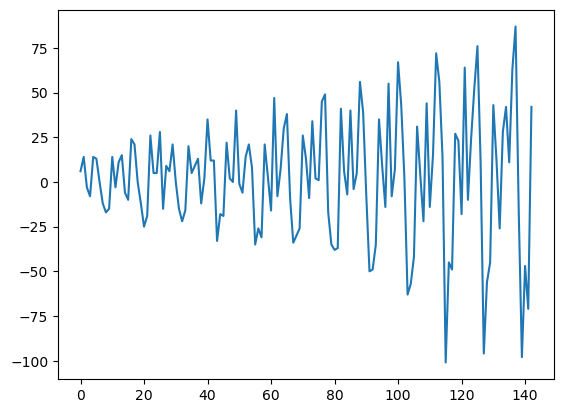

In [21]:
plt.plot(ts_stationary)

In [22]:
ts_undiff = revert_differenciating(ts_stationary, offset)
ts_undiff[0:10]

array([118., 132., 129., 121., 135., 148., 148., 136., 119., 104.],
      dtype=float32)

In [23]:
ts_undiff.shape

(143,)

#### Normalize / inverse normalize

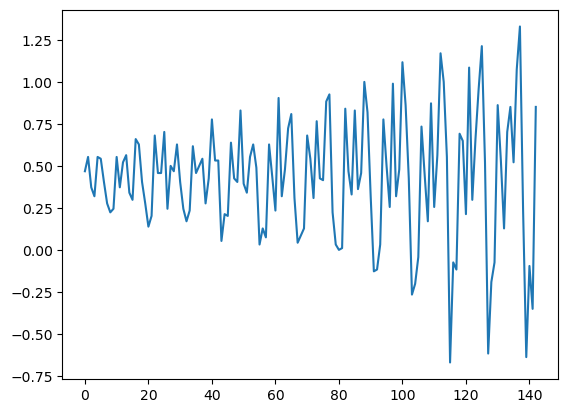

In [24]:
scaler2 = MinMaxScaler(feature_range=(0, 1))
scaler_min_max2 = scaler2.fit(ts_stationary.reshape(-1,1)[0:91])
ts_stationary_normalized = scaler_min_max2.transform(ts_stationary.reshape(-1,1))
# back to 1D
ts_stationary_normalized_1D = ts_stationary_normalized.flatten()
plt.plot(ts_stationary_normalized_1D)

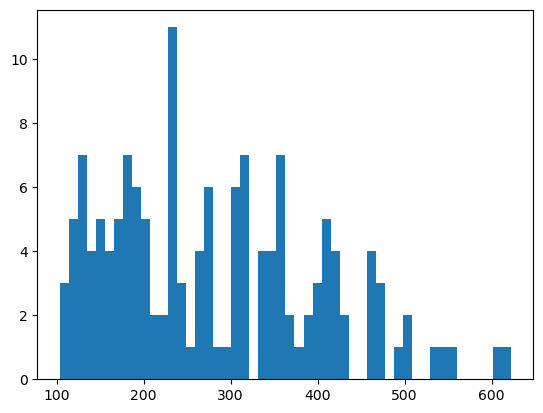

In [25]:
# initial shape - just check data distribution shape (gaussian or not)
hist = plt.hist(ts, bins=50)

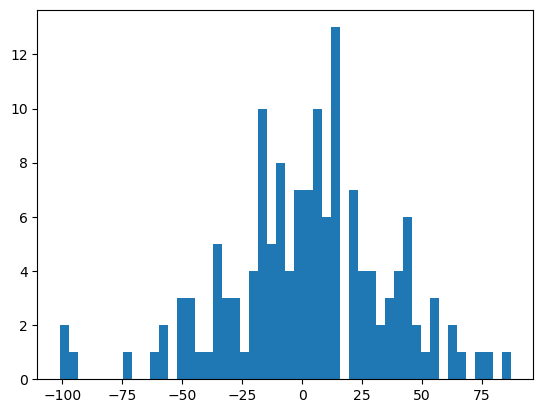

In [26]:
_ = plt.hist(ts_stationary, bins=50)

Data **not** made stationary prior :

In [27]:
scaler, ts_normalized = normalize(ts)
print(ts_normalized[0:10])
print(ts_normalized.ndim)

[0.01544401 0.02702703 0.05405405 0.04826255 0.03281853 0.05984557
 0.08494207 0.08494207 0.06177607 0.02895753]
1


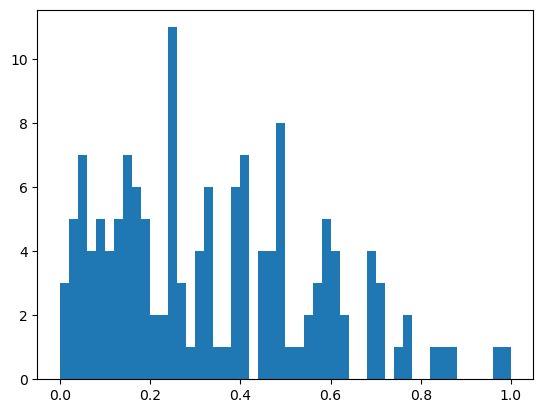

In [28]:
_ = plt.hist(ts_normalized, bins=50)

In [29]:
time_series_inverse = inverse_normalize(scaler, ts_normalized)
print(time_series_inverse[0:10])
print(time_series_inverse.ndim)

[112. 118. 132. 129. 121. 135. 148. 148. 136. 119.]
1


Data made **stationary** prior :

In [30]:
scaler, ts_normalized2 = normalize(ts_stationary)
print(ts_normalized2[0:10])
print(ts_normalized2.ndim)

[0.5691489  0.6117021  0.52127653 0.49468082 0.6117021  0.60638297
 0.537234   0.47340423 0.4468085  0.45744678]
1


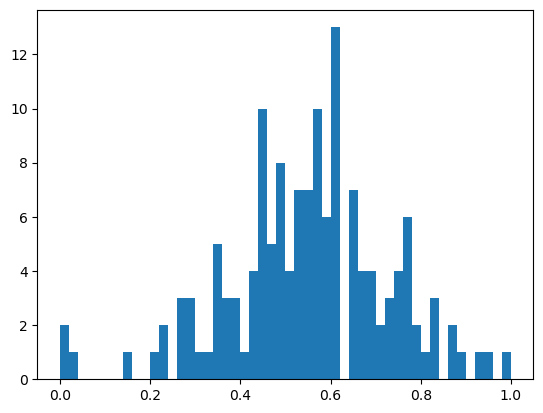

In [31]:
_ = plt.hist(ts_normalized2, bins=50)

## LTSM Pytorch modeling

### Reshape dataset

- Here, Univariate : one feature (number of passengers). We could have added / built others from date.
- Several ways to prepare dataset for lstm/time series : 
    - e.g. multiple inputs -> multiple outputs vs. multiple inputs -> single output
    - hopping/overlapping windows, step size of the sliding window... (we're using 1 below)
- Convert a time series into a tensor of dimensions (window sample, time steps, features)  
- Below : multiple (4) inputs -> multiple outputs/targets (4)

In [32]:
def create_dataset(dataset, lookback):
    """
    Transform a time series into a prediction dataset
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    Output: Pytorch 3D tensors
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    # Optional but prevent warning performance message :
    # Convert the lists to numpy arrays and then to Pytorch tensors.
    X = torch.tensor(np.array(X))
    y = torch.tensor(np.array(y))
    return X, y

#### Optional : Test create dataset / reshape array

In [33]:
# input must be a 2D array
train, test = to_2d(train), to_2d(test)
train[0:3]

array([[112.],
       [118.],
       [132.]], dtype=float32)

In [34]:
train.shape

(96, 1)

In [35]:
train.ndim

2

In [36]:
lookback = 4
dataset_X_train, dataset_y_train = create_dataset(train, lookback)
dataset_X_test, dataset_y_test = create_dataset(test, lookback)

In [37]:
train[0:6]

array([[112.],
       [118.],
       [132.],
       [129.],
       [121.],
       [135.]], dtype=float32)

In [38]:
dataset_X_train[0:2]

tensor([[[112.],
         [118.],
         [132.],
         [129.]],

        [[118.],
         [132.],
         [129.],
         [121.]]])

In [39]:
dataset_y_train[0:2]

tensor([[[118.],
         [132.],
         [129.],
         [121.]],

        [[132.],
         [129.],
         [121.],
         [135.]]])

In [40]:
print(dataset_X_train.shape, dataset_y_train.shape)

torch.Size([92, 4, 1]) torch.Size([92, 4, 1])


In [41]:
print(dataset_X_test.shape, dataset_y_test.shape)

torch.Size([44, 4, 1]) torch.Size([44, 4, 1])


### Create LSTM model

Refer to [source](https://machinelearningmastery.com/lstm-for-time-series-prediction-in-pytorch/)

In [42]:
class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

## Train Model, Part 1 : vanilla, no prior ts made stationarity and scaling

- regression problem -> mse (or rmse) as loss function
- batch for training provided by DataLoader (torch.utils.data)
- model performance is evaluated once per 100 epochs

In [43]:
# input/output 1D array time series (ts)
train_size = int(len(ts) * 0.67)
test_size = len(ts) - train_size
train, test = ts[:train_size], ts[train_size:]

In [44]:
# specific to our choice to work with 1d input (useful for part 2.)
train, test = to_2d(train), to_2d(test)

# create dataset with correct shape

lookback = 4
X_train, y_train = create_dataset(train, lookback)
X_test, y_test = create_dataset(test, lookback)

In [45]:
# sanity check
print(train.ndim, X_train.ndim)

2 3


In [ ]:
model = AirModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

n_epochs = 3000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 225.6342, test RMSE 424.8375
Epoch 100: train RMSE 174.6111, test RMSE 371.2721
Epoch 200: train RMSE 136.3254, test RMSE 329.1001
Epoch 300: train RMSE 106.0394, test RMSE 292.2979
Epoch 400: train RMSE 84.1444, test RMSE 260.6419
Epoch 500: train RMSE 63.8709, test RMSE 228.9224
Epoch 600: train RMSE 50.2286, test RMSE 201.8940
Epoch 700: train RMSE 40.8480, test RMSE 178.2801
Epoch 800: train RMSE 34.1413, test RMSE 157.8755
Epoch 900: train RMSE 29.8713, test RMSE 140.2291
Epoch 1000: train RMSE 26.6341, test RMSE 125.7914
Epoch 1100: train RMSE 25.1665, test RMSE 113.7629
Epoch 1200: train RMSE 23.3230, test RMSE 104.1430
Epoch 1300: train RMSE 22.0493, test RMSE 97.0154
Epoch 1400: train RMSE 21.4190, test RMSE 90.9635
Epoch 1500: train RMSE 20.9292, test RMSE 85.7293
Epoch 1600: train RMSE 20.4427, test RMSE 83.2529
Epoch 1700: train RMSE 20.0004, test RMSE 80.8345
Epoch 1800: train RMSE 19.6992, test RMSE 78.2824
Epoch 1900: train RMSE 19.4725, test RMSE 76.

#### Plot the output

Take the model’s output as y_pred but extract only the data from the last time step as y_pred[:, -1, :]. This is what is plotted on the chart.

In [ ]:
timeseries = ts2 # original data, as a 2d array input

with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]
# plot
plt.plot(timeseries)
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()

## Train Model, Part 2 : with prior data made stationarity and normalization (minmax) applied

This time, 1. make data stationary (whole dataset) 2. scale (minmax). Benchmark vs. "simple" approach in Part I. to see if any improvement.

#### Make data stationary (see steps/remarks in introduction)

In [ ]:
plt.plot(ts)

In [ ]:
# Optional : save offset for later revert-differenciating
offset = get_offset(ts)
offset

In [ ]:
# make stationary
ts_stationary = make_stationary(ts)
plt.plot(ts_stationary)

#### Train-test split

In [ ]:
# input/output 1D array time series (ts)
train_size = int(len(ts_stationary) * 0.67)
test_size = len(ts_stationary) - train_size
train, test = ts_stationary[:train_size], ts_stationary[train_size:]

#### Normalization (minmax scaling)

In [ ]:
# fit on train, tranform train
scaler_min_max, train_normalized = normalize(train)
print(scaler_min_max)
plt.plot(train_normalized)

In [ ]:
# transform test.
# Notice that boundaries  > or < than 0/1. because high upward trend in test data 
# Real life / Domain knowledge / different normalization maye "solve" that, but let's see if it is really an issue.
test_normalized = scaler_min_max.transform(test.reshape(-1,1)).flatten()
print(test_normalized.ndim)
plt.plot(test_normalized)

#### Train model

In [ ]:
# specific to our choice to work with 1d input (useful for part 2.)
train, test = to_2d(train_normalized), to_2d(test_normalized)

In [ ]:

# create dataset with correct shape
lookback = 4
X_train, y_train = create_dataset(train, lookback)
X_test, y_test = create_dataset(test, lookback)

In [ ]:
model = AirModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

n_epochs = 800
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

#### Model output/evaluation : model performance visualization **without** un-differenciating / un-scaling

Visualize model prediction, we did not revert stationarity / minmax scaling. See how the model seems to predict better.  
We still have to apply our transformations to have a comparable mse/rmse to part 1. Also the transfomations may amplify the "(in)accuracy" of the model once applied (we may verify that below)

In [ ]:
# Input time series
# make sure our initial timeseries is a 2d array
timeseries = np.append(train, test)
timeseries = to_2d(timeseries)
plt.plot(timeseries)

In [ ]:
# visualize model performance

with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :] 
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]
# plot
plt.plot(timeseries)
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()

#### Unscaled/undifferenciated model output/evaluation : model performance visualization with un-differenciating / un-scaling applied

In [ ]:
print(timeseries[0:2])
print("ndim: ", timeseries.ndim)
print("shape: ", timeseries.shape)

#### tmp / reproduction, with annotations


In [ ]:
with torch.no_grad():
    # 1. train_plot : create an array filled with NaN, as equaly shaped as initial timeseries (ndim 2, shape 143, 1)
    # we will fill it below with model predictions on train data, and plot it in red
    train_plot = np.ones_like(timeseries) * np.nan
    
    # optional (redundant with line below)
    y_pred = model(X_train)
    # retain only the last (4th) value of each [1,2,3,4] input, output is a 2d array
    y_pred = y_pred[:, -1, :]
    
    # the line below is redundant/equivalent to doing y_pred and then y_pred[:, -1, :] (lines above),
    # except we will retain only the model prediction on train (4 -> length of train size), nan values before (4) and after.
    # shift train predictions for plotting
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    
    # 2. test plot : create an array filled with NaN, as equaly shaped as initial timeseries (ndim 2, shape 143, 1)
    test_plot = np.ones_like(timeseries) * np.nan
    # shift test predictions for plotting
    # 4 NaN (input data size) then model predictions on X_test
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]

# plot
plt.plot(timeseries)
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()

In [ ]:
train_size

In [ ]:
test_size

In [ ]:
train_size+test_size

In [ ]:
with torch.no_grad():
    
    # 0. time series (true values)
    # unscale timeseries
    timeseries_unscaled = inverse_normalize(scaler_min_max, timeseries)
    timeseries_original = revert_differenciating(timeseries_unscaled, offset)
    timeseries_original = to_2d(timeseries_original)
    
    # 1. get offset values, so we can do reverse differencing on train and test
    # idea is to get the last value of original data, and use as "first value" (offset) to reverse diff
    offset_train = 112
    offset_test = 306
    
    # 2. create train plot

    # create an array of size timeseries and fill with NaN
    train_plot = np.ones_like(timeseries_original) * np.nan
    # apply model prediction on train data
    y_pred = model(X_train)
    # reshape train predictions, keep only the 4th/last/-1 value for each of 4 values input sequence.
    # result is a 2dim array of shape [91, 1], in place of [91, 4, 1]
    y_pred = y_pred[:, -1, :]

    # revert min max scaling
    y_pred = inverse_normalize(scaler_min_max, y_pred)
    # revert 1st order differenciating
    y_pred = revert_differenciating(y_pred, offset_train)
    # convert back to a 2D array (inverse_normalize/diff outputs are 1D...)
    y_pred = to_2d(y_pred)
    # shift train predictions for plotting. 4 NaN values, then train predictions, then NaN values again
    train_plot[lookback:train_size] = y_pred
    
    # 3. create test plot
    
    test_plot = np.ones_like(timeseries_original) * np.nan
    y_pred_test = model(X_test)
    y_pred_test = y_pred_test[:, -1, :]
    y_pred_test = inverse_normalize(scaler_min_max, y_pred_test)
    y_pred_test = revert_differenciating(y_pred_test, offset_test)
    y_pred_test = to_2d(y_pred_test)
    test_plot[train_size+lookback:len(timeseries_original)] = y_pred_test
    
# plot
plt.plot(timeseries_original)
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()

### Benchmark / Note

Differencing + scaling vs. without : 
- Faster convergence (900 epochs vs. 3000). The scaling is generally said to help here (don't know about the stationarity)